# Agent Memory Project

## Load env

In [2]:
import os
import openai

from openai import OpenAI
from dotenv import load_dotenv
from pathlib import Path

# Load path from the environment variable
env_ih1 = os.getenv("ENV_IH1")

dotenv_path = Path(env_ih1)
load_dotenv(dotenv_path=dotenv_path)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
PINECONE_API_KEY= os.getenv('PINECONE_KEY')
SERPAPI_API_KEY = os.getenv('SERPAPI_API_KEY')
STEAMSHIP_API_KEY = os.getenv('STEAMSHIP_API_KEY')
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')
HUGGINGFACEHUB_API_TOKEN = os.getenv('HUGGINGFACEHUB_API_TOKEN')
GEMINI_KEY = os.getenv('GEMINI_KEY')

os.environ['PATH'] += os.pathsep + '/usr/bin'

In [3]:
from langsmith import wrappers, traceable

LANGSMITH_API_KEY= LANGSMITH_API_KEY
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"]="memory-project"

## Load Pinecone DB

In [4]:
import time
from pinecone import Pinecone

# configure client
pc = Pinecone(api_key=PINECONE_API_KEY)

# Connect to the existing index
index_name = "memory-project3"  # Replace with your existing index name
# connect to index
index = pc.Index(index_name)
time.sleep(1)
# view index stats
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 1014}},
 'total_vector_count': 1014}

In [5]:
from langchain.vectorstores import Pinecone as LangchainPinecone
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.schema import Document

## Create encoder
from semantic_router.encoders import OpenAIEncoder

encoder = OpenAIEncoder(
    name="text-embedding-3-small",
    openai_api_key=OPENAI_API_KEY 
)

## Creating retriever

# Initialize OpenAI Embeddings with text-embedding-3-small
embeddings = OpenAIEmbeddings(model="text-embedding-3-small", openai_api_key=OPENAI_API_KEY)

# Initialize LangChain Pinecone retriever
vectorstore = LangchainPinecone(index, embeddings, text_key="text")
retriever = vectorstore.as_retriever()

C:\Users\aurel\AppData\Local\Temp\ipykernel_17280\1506975490.py:16: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings(model="text-embedding-3-small", openai_api_key=OPENAI_API_KEY)
C:\Users\aurel\AppData\Local\Temp\ipykernel_17280\1506975490.py:19: LangChainDeprecationWarning: The class `Pinecone` was deprecated in LangChain 0.0.18 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-pinecone package and should be used instead. To use it run `pip install -U :class:`~langchain-pinecone` and import as `from :class:`~langchain_pinecone import Pinecone``.
  vectorstore = LangchainPinecone(index, embeddings, text_key=

In [6]:
# Test retrieval
query = "Who is Jean Lambert?"
results = retriever.get_relevant_documents(query)

# Print results
for doc in results:
    print(f"Content: {doc.page_content}")
    print(f"Metadata: {doc.metadata}")
    print("-" * 50)

C:\Users\aurel\AppData\Local\Temp\ipykernel_17280\3093734283.py:3: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  results = retriever.get_relevant_documents(query)


Content: POUR LA MÉMOIRE
FAMILIALE

FAMILLE HISTOIRE
SOUVENIRS & COMMENTAIRES

VOLUME 1

Jean-Georges Lambert
Avril 1993
Metadata: {'Author': 'Jean Lambert', 'Chunk_ID': 'Pour la mémoire familiale 1-50_Chunk1', 'Doc name': 'Pour la mémoire familiale 1-50', 'Page_number': 1.0, 'Total_Chunks': 1.0}
--------------------------------------------------
Content: C'est le dernier, Isaac, dit Hovel, le plus souvent appelé Louis qui est notre ancêtre direct à la génération suivante.

Il est né en 1766 à Froeningen, et s'est marié avec Rachel (ou Reiche ou Rosalie ou Thérèse) Gugenheim, née également à Froeningen en 1772, et décédée dans le même village en 1843, à 81 ans.

Du ménage Louis et Rachel, je connais six enfants: Charlotte ex Judele, Jacques ex Jacob, marchand de bestiaux, Alexandre ex Samuel, marchand de bestiaux, Lehmann ou Clément, Marx, marchand de bétail, et Julie ex Sara, tous nés à Froeningen entre 1795 et 1802.
Metadata: {'Author': 'John Doe', 'Chunk_ID': 'Pdf img_Chunk1', 'Doc 

## Define tools

In [70]:
import requests
import json
from pprint import pformat
import ast
from langchain_core.tools import Tool
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState


# Defining Tools
##################################################################################

def format_rag_contexts(matches: list):
    """Formats retrieved document matches into a readable context string."""
    contexts = []
    for x in matches:
        metadata = x.get("metadata", {})  # Safely get metadata
        text = (
            f"Doc name: {metadata.get('Doc name', 'N/A')}\n"
            f"Author: {metadata.get('Author', 'N/A')}\n"
            f"Chunk_ID: {metadata.get('Chunk_ID', 'N/A')}\n"
            f"Content: {metadata.get('text', 'No content available')}"  # Fixed page content reference
        )
        contexts.append(text)

    return "\n---\n".join(contexts)


def translate_to_french(query: str):
    """Translates the given query to French using OpenAI's `o4-mini` model to improve retriebal in French database."""
    
    response = openai.ChatCompletion.create(
        model="gpt-4o",  # "o4-mini" may refer to "gpt-4o"
        messages=[
            {"role": "system", "content": "You are a translation assistant."},
            {"role": "user", "content": f"Translate the following text to French:\n{query}"}
        ],
        temperature=0
    )

    return response

    

from typing import List, Union
from langchain.tools import tool
import re



def rag_search(query: str):
    """Finds related information using a natural language query in the family history."""

    xq = encoder([query])
    xc = index.query(vector=xq, top_k=3, include_metadata=True)

    if "matches" not in xc or not xc["matches"]:
        return "⚠ No relevant documents found."

    # Extract best match details
    best_match = xc["matches"][0]
    chunk_id = best_match["metadata"].get("Chunk_ID", "")
    doc_name = best_match["metadata"].get("Doc name", "")
    total_chunks = best_match["metadata"].get("Total_Chunks", 1)  # Default to 1 if missing

    try:
        total_chunks = int(float(total_chunks))  # Ensure integer conversion from float or string
    except (ValueError, TypeError):
        total_chunks = 1  # Fallback in case of conversion error

    print(f"🔍 Best Match - Doc: {doc_name}, Chunk: {chunk_id}, Total Chunks: {total_chunks}")

    # Extract chunk number
    match = re.match(r"(.+)_Chunk(\d+)", chunk_id)
    if not match:
        return format_rag_contexts(xc["matches"])  # Return base context if extraction fails

    _, chunk_num = match.groups()

    try:
        chunk_num = int(chunk_num)  # Ensure chunk_num is an integer
    except ValueError:
        return format_rag_contexts(xc["matches"])  # Fallback in case of error

    # Debug: Print extracted chunk numbers before range calculation
    print(f"🔢 Extracted Chunk Number: {chunk_num}, Total Chunks: {total_chunks}")

    # Generate **bounded** chunk IDs within valid range
    min_chunk = max(1, chunk_num - 3)
    max_chunk = min(total_chunks, chunk_num + 3)

    # Debug: Check type before using in range
    print(f"🔍 Before Casting - min_chunk: {min_chunk} ({type(min_chunk)}), max_chunk: {max_chunk} ({type(max_chunk)})")

    # Ensure integer conversion
    min_chunk = int(min_chunk)
    max_chunk = int(max_chunk)

    # Debug: Confirm type after casting
    print(f"✅ After Casting - min_chunk: {min_chunk} ({type(min_chunk)}), max_chunk: {max_chunk} ({type(max_chunk)})")

    expanded_chunk_ids = [f"{doc_name}_Chunk{i}" for i in range(min_chunk, max_chunk + 1)]

    print(f"🧩 Expanding context with bounded chunks: {expanded_chunk_ids}")

    # Retrieve expanded chunks
    expanded_contexts = []
    for expanded_chunk in expanded_chunk_ids:
        try:
            result = chunk_search.run(expanded_chunk)
            if result and "⚠ No context found" not in result:
                expanded_contexts.append(result)
        except Exception as e:
            print(f"⚠ Error retrieving chunk {expanded_chunk}: {str(e)}")

    # Combine and return formatted context
    full_context = "\n\n".join(expanded_contexts) if expanded_contexts else format_rag_contexts(xc["matches"])
    return full_context







# Tool for chunk search
def chunk_search(query: str, chunk_id: str):
    """Finds related information based on the chunk_id. Helps to get more context."""

    # Extract Doc Name and Chunk Number from chunk_id
    match = re.match(r"(.+)_Chunk(\d+)", chunk_id)
    if not match:
        return f"❌ Error: Invalid chunk_id format '{chunk_id}'"

    doc_name, chunk_number = match.groups()
    chunk_number = int(chunk_number)

    # Generate surrounding chunk IDs (-2, -1, +1, +2)
    chunk_ids = [f"{doc_name}_Chunk{i}" for i in range(chunk_number - 10, chunk_number + 10) if i > 0]

    print(f"🔍 Debugging Chunk IDs: {chunk_ids}")

    # Encode query into a vector (Replace `encoder()` with your actual embedding function)
    xq = encoder([query])  # Convert query into vector

    try:
        # Perform a **vector-based search** instead of only filtering by chunk ID
        response = index.query(
            vector=xq,
            namespace="",
            filter={"Chunk_ID": {"$in": chunk_ids}},  # Ensure correct filter usage
            top_k=5,  # Fetch relevant results
            include_metadata=True
        )
        direct_matches = response["matches"]

    except Exception as e:
        return f"❌ Pinecone Query Error: {str(e)}"

    # Format and return results
    results = []
    for match in direct_matches:
        metadata = match.get("metadata", {})
        chunk_text = metadata.get("text", "No content available")
        chunk_id_match = metadata.get("Chunk_ID", "Unknown Chunk")
        results.append(f"📜 Found Chunk: {chunk_id_match} -> {chunk_text}...")  # Limit text preview

    return "\n".join(results) if results else "⚠ No relevant chunks found."

from langchain_core.prompts import PromptTemplate

def final_answer(answer: str, explore_next: str = "Would you like to ask about another topic?", sources: str = None):
    """
    Formats the final answer using a structured approach.

    Args:
        answer (str): The main response.
        explore_next (str, optional): Suggested next question.
        sources (str, optional): Source references.

    Returns:
        str: A well-structured response.
    """

    # 🔹 Construct sources section only if sources are available
    sources_section = f"- **Sources**: {sources}" if sources and sources.lower() != 'none' else ""

    # 🔹 Define the structured prompt within the function
    final_answer_prompt = PromptTemplate.from_template("""
    You are an intelligent assistant helping with historical research.
    Format the final answer for the user by including:

    - **Answer**: {answer}
    {sources_section}
    - **Explore Next**: {explore_next}

    Ensure the response is clear and well-structured.
    """)

    # 🔹 Ensure all fields are properly formatted before passing to the prompt
    structured_input = {
        "answer": answer,
        "explore_next": explore_next if explore_next else "No further suggestions.",
        "sources_section": sources_section
    }

    # 🔹 Use the embedded prompt template to format the response
    formatted_response = final_answer_prompt.format(**structured_input)

    return formatted_response  # ✅ Always returns a well-structured response



# Binding tools to the LLM
##################################################################################

# Create tool bindings with additional attributes
from langchain.tools import Tool

# Tool for formatting RAG contexts
format_rag_contexts_tool = Tool.from_function(
    func=format_rag_contexts,
    name="format_rag_contexts",
    description="Formats retrieved document matches into a readable context string.",
    return_direct=False
)

# Tool for translating text to French
translate_to_french_tool = Tool.from_function(
    func=translate_to_french,
    name="translate_to_french",
    description="Translates the given query to French using OpenAI's GPT-4o model to improve retrieval in a French database.",
    return_direct=False
)

# Tool for RAG search
rag_search_tool = Tool.from_function(
    func=rag_search,
    name="rag_search",
    description="Finds related information using a natural language query in the family history database.",
    return_direct=False
)

# Tool for chunk search
chunk_search_tool = Tool.from_function(
    func=chunk_search,
    name="chunk_search",
    description="Finds related information based on the chunk_id, helping to get more context around a given chunk.",
    return_direct=False
)

# Tool for final answer generation
final_answer_tool = Tool.from_function(
    func=final_answer,
    name="final_answer",
    description=(
        "Generates a natural language response to the user's question based on the family memory database. "
        "Links information together from multiple sources but does not invent new information. "
        "If no answer is found, it explicitly states that it doesn't know."
    ),
    return_direct=False
)

# List of all tools
toolbox = [
    format_rag_contexts_tool,
    translate_to_french_tool,
    rag_search_tool,
    chunk_search_tool,
    final_answer_tool
]


# OPENAI_API_KEY environment variable must be set
simple_llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = simple_llm.bind_tools(toolbox)


# Defining Agent's node
##################################################################################

# System message
assistant_system_message = SystemMessage(content=("""You are the Family Safe, keeper of the family's collective memory. 
Your role is to decide how to handle user queries using the available tools.

**Tool Usage:**
- Do NOT reuse a tool for the same query (check the scratchpad).
- Do NOT use any tool more than **3 times**.
- Prioritize **rag_search** for gathering information.
- Use **chunk_search** to find context around a specific chunk.
- Do not mix sources from different contexts unless necessary.
- Alsways check at leats 2 ***Doc name*** to ensure the information is correct.

**Response Protocol:**
- If tools provides no answer, state that you don't know or can't any information about this topic"
- NEVER invent information or use data beyond the family memory.
- Always provide sources via the **final_answer** tool.
- Chunk_search must be in the scracthpad to point to final_answer.
- Discard any page content that looks like a table of content: you won't find any useful information there apart from page numbers.

By following these rules, you ensure accurate and responsible responses."""))

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([assistant_system_message] + state["messages"])]}


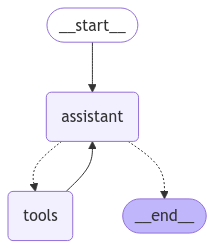

In [71]:
from langgraph.checkpoint.memory import MemorySaver

# Defining Graph
##################################################################################

from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(toolbox))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
react_graph_with_memory = builder.compile(checkpointer=memory)

# Show
display(Image(react_graph_with_memory.get_graph(xray=True).draw_mermaid_png()))

# Define oracle function
################################################################################################

# Specify a thread
def oracle(user_request: str, thread_id = "1", verbose = False):
    config = {"configurable": {"thread_id": thread_id}}
    messages = react_graph_with_memory.invoke({"messages": [HumanMessage(content=user_request)]}, config)
    if verbose:
        for message in messages['messages']:
            message.pretty_print()
    else:
        messages['messages'][-1].pretty_print()

In [72]:
oracle(
    user_request="Yes, tell me more about his mother.", 
    thread_id="3"
)

🔍 Best Match - Doc: Pour la mémoire familiale 1-50, Chunk: Pour la mémoire familiale 1-50_Chunk5, Total Chunks: 6
🔢 Extracted Chunk Number: 5, Total Chunks: 6
🔍 Before Casting - min_chunk: 2 (<class 'int'>), max_chunk: 6 (<class 'int'>)
✅ After Casting - min_chunk: 2 (<class 'int'>), max_chunk: 6 (<class 'int'>)
🧩 Expanding context with bounded chunks: ['Pour la mémoire familiale 1-50_Chunk2', 'Pour la mémoire familiale 1-50_Chunk3', 'Pour la mémoire familiale 1-50_Chunk4', 'Pour la mémoire familiale 1-50_Chunk5', 'Pour la mémoire familiale 1-50_Chunk6']
⚠ Error retrieving chunk Pour la mémoire familiale 1-50_Chunk2: 'function' object has no attribute 'run'
⚠ Error retrieving chunk Pour la mémoire familiale 1-50_Chunk3: 'function' object has no attribute 'run'
⚠ Error retrieving chunk Pour la mémoire familiale 1-50_Chunk4: 'function' object has no attribute 'run'
⚠ Error retrieving chunk Pour la mémoire familiale 1-50_Chunk5: 'function' object has no attribute 'run'
⚠ Error retrieving 

In [45]:
oracle(
    user_request="When did Jean start to write this book?", 
    thread_id="5"
)

🔍 Best Match - Doc: Pour la mémoire familiale 1-50, Chunk: Pour la mémoire familiale 1-50_Chunk1, Total Chunks: 1
🔢 Extracted Chunk Number: 1, Total Chunks: 1
🔍 Before Casting - min_chunk: 1 (<class 'int'>), max_chunk: 1 (<class 'int'>)
✅ After Casting - min_chunk: 1 (<class 'int'>), max_chunk: 1 (<class 'int'>)
🧩 Expanding context with bounded chunks: ['Pour la mémoire familiale 1-50_Chunk1']
⚠ Error retrieving chunk Pour la mémoire familiale 1-50_Chunk1: 'function' object has no attribute 'run'
🔍 Best Match - Doc: Pour la mémoire familiale 1-50, Chunk: Pour la mémoire familiale 1-50_Chunk1, Total Chunks: 1
🔢 Extracted Chunk Number: 1, Total Chunks: 1
🔍 Before Casting - min_chunk: 1 (<class 'int'>), max_chunk: 1 (<class 'int'>)
✅ After Casting - min_chunk: 1 (<class 'int'>), max_chunk: 1 (<class 'int'>)
🧩 Expanding context with bounded chunks: ['Pour la mémoire familiale 1-50_Chunk1']
⚠ Error retrieving chunk Pour la mémoire familiale 1-50_Chunk1: 'function' object has no attribute 'r

In [46]:
oracle(
    user_request="When did Jean's mother died?", 
    thread_id="5"
)

🔍 Best Match - Doc: Pour la mémoire familiale 1-50, Chunk: Pour la mémoire familiale 1-50_Chunk1, Total Chunks: 1
🔢 Extracted Chunk Number: 1, Total Chunks: 1
🔍 Before Casting - min_chunk: 1 (<class 'int'>), max_chunk: 1 (<class 'int'>)
✅ After Casting - min_chunk: 1 (<class 'int'>), max_chunk: 1 (<class 'int'>)
🧩 Expanding context with bounded chunks: ['Pour la mémoire familiale 1-50_Chunk1']
⚠ Error retrieving chunk Pour la mémoire familiale 1-50_Chunk1: 'function' object has no attribute 'run'
🔍 Best Match - Doc: Pour la mémoire familiale 1-50, Chunk: Pour la mémoire familiale 1-50_Chunk1, Total Chunks: 1
🔢 Extracted Chunk Number: 1, Total Chunks: 1
🔍 Before Casting - min_chunk: 1 (<class 'int'>), max_chunk: 1 (<class 'int'>)
✅ After Casting - min_chunk: 1 (<class 'int'>), max_chunk: 1 (<class 'int'>)
🧩 Expanding context with bounded chunks: ['Pour la mémoire familiale 1-50_Chunk1']
⚠ Error retrieving chunk Pour la mémoire familiale 1-50_Chunk1: 'function' object has no attribute 'r

In [73]:
oracle(
    user_request="What happened on March 29, 1963?", 
    thread_id="7"
)

🔍 Best Match - Doc: Pour la mémoire familiale 1-50, Chunk: Pour la mémoire familiale 1-50_Chunk3, Total Chunks: 3
🔢 Extracted Chunk Number: 3, Total Chunks: 3
🔍 Before Casting - min_chunk: 1 (<class 'int'>), max_chunk: 3 (<class 'int'>)
✅ After Casting - min_chunk: 1 (<class 'int'>), max_chunk: 3 (<class 'int'>)
🧩 Expanding context with bounded chunks: ['Pour la mémoire familiale 1-50_Chunk1', 'Pour la mémoire familiale 1-50_Chunk2', 'Pour la mémoire familiale 1-50_Chunk3']
⚠ Error retrieving chunk Pour la mémoire familiale 1-50_Chunk1: 'function' object has no attribute 'run'
⚠ Error retrieving chunk Pour la mémoire familiale 1-50_Chunk2: 'function' object has no attribute 'run'
⚠ Error retrieving chunk Pour la mémoire familiale 1-50_Chunk3: 'function' object has no attribute 'run'
================================== Ai Message ==================================

**Answer**: Le 29 mars 1963, la mère de Jean Lambert est décédée. À cette époque, William n'était pas encore né, et Georges 

In [74]:
oracle(
    user_request="Combien d'enfant a Jean?", 
    thread_id="9"
)

🔍 Best Match - Doc: Pdf img, Chunk: Pdf img_Chunk6, Total Chunks: 8
🔢 Extracted Chunk Number: 6, Total Chunks: 8
🔍 Before Casting - min_chunk: 3 (<class 'int'>), max_chunk: 8 (<class 'int'>)
✅ After Casting - min_chunk: 3 (<class 'int'>), max_chunk: 8 (<class 'int'>)
🧩 Expanding context with bounded chunks: ['Pdf img_Chunk3', 'Pdf img_Chunk4', 'Pdf img_Chunk5', 'Pdf img_Chunk6', 'Pdf img_Chunk7', 'Pdf img_Chunk8']
⚠ Error retrieving chunk Pdf img_Chunk3: 'function' object has no attribute 'run'
⚠ Error retrieving chunk Pdf img_Chunk4: 'function' object has no attribute 'run'
⚠ Error retrieving chunk Pdf img_Chunk5: 'function' object has no attribute 'run'
⚠ Error retrieving chunk Pdf img_Chunk6: 'function' object has no attribute 'run'
⚠ Error retrieving chunk Pdf img_Chunk7: 'function' object has no attribute 'run'
⚠ Error retrieving chunk Pdf img_Chunk8: 'function' object has no attribute 'run'
🔍 Best Match - Doc: Pdf img, Chunk: Pdf img_Chunk1, Total Chunks: 8
🔢 Extracted Chunk Numb

In [75]:
oracle(
    user_request="Can you check for sons in chunk 7 & 8?", 
    thread_id="7"
)

================================== Ai Message ==================================

It seems there is a technical issue with retrieving information from chunks 7 and 8. I am unable to check for details about sons in those chunks at this moment. 

If you have other topics or specific names you're interested in, please let me know!


In [ ]:
oracle(
    user_request="Who are Jean's sons?", 
    thread_id="8"
)

================================== Ai Message ==================================

**Answer**: In the family's collective memory documented by Jean Lambert, there is mention of his father's perspective on the Dreyfus affair, which highlights the contextual antisemitism prevalent at the time. Jean's reflections seem to intertwine personal experiences and the larger societal issues surrounding the Dreyfus affair, shedding light on how his family viewed the events and their impact. Specific opinions or feelings expressed by Jean regarding the Dreyfus case may not be detailed, but there is an acknowledgment of the affair's significance and the resultant changes in public discourse about antisemitism.

**Explore Next**: Would you like to ask about another topic?


In [79]:
oracle(
    user_request="What can you tell me about Jacques Drefyus?", 
    thread_id="10"
)

🔍 Best Match - Doc: Pour la mémoire familiale 1-50, Chunk: Pour la mémoire familiale 1-50_Chunk3, Total Chunks: 3
🔢 Extracted Chunk Number: 3, Total Chunks: 3
🔍 Before Casting - min_chunk: 1 (<class 'int'>), max_chunk: 3 (<class 'int'>)
✅ After Casting - min_chunk: 1 (<class 'int'>), max_chunk: 3 (<class 'int'>)
🧩 Expanding context with bounded chunks: ['Pour la mémoire familiale 1-50_Chunk1', 'Pour la mémoire familiale 1-50_Chunk2', 'Pour la mémoire familiale 1-50_Chunk3']
⚠ Error retrieving chunk Pour la mémoire familiale 1-50_Chunk1: 'function' object has no attribute 'run'
⚠ Error retrieving chunk Pour la mémoire familiale 1-50_Chunk2: 'function' object has no attribute 'run'
⚠ Error retrieving chunk Pour la mémoire familiale 1-50_Chunk3: 'function' object has no attribute 'run'
================================== Ai Message ==================================

**Answer**: There is no information found regarding whether William has any other brothers apart from Georges. The available